In [1]:
import requests
from tabulate import tabulate

GUTENDEX_API_BASE_URL = 'https://gutendex.com'
author_year_start = 1808
author_year_end = 1890
gutendex_url = f'{GUTENDEX_API_BASE_URL}/books?author_year_start={author_year_start}&author_year_end={author_year_end}'

response = requests.get(gutendex_url)

if response.status_code == 200:
    data = response.json()

    if 'results' in data and isinstance(data['results'], list):
        books = data['results']

        if books:
            table_data = []

            for book in books:
                book_id = book.get('id', '')
                title = book.get('title', '')

                authors_list = book.get('authors', [])
                authors = ", ".join(author['name'] for author in authors_list)

                table_data.append([book_id, title[:50], authors])

            headers = ["Book ID", "Title", "Authors"]
            table = tabulate(table_data, headers=headers, tablefmt="pipe")

            print(table)
        else:
            print("No books found in the specified range of years.")
    else:
        print("Invalid or missing 'results' key in the data dictionary.")
else:
    print(f"Failed to retrieve data. Status code: {response.status_code}")

|   Book ID | Title                                             | Authors                        |
|----------:|:--------------------------------------------------|:-------------------------------|
|      2701 | Moby Dick; Or, The Whale                          | Melville, Herman               |
|      2641 | A Room with a View                                | Forster, E. M. (Edward Morgan) |
|       145 | Middlemarch                                       | Eliot, George                  |
|     37106 | Little Women; Or, Meg, Jo, Beth, and Amy          | Alcott, Louisa May             |
|     16389 | The Enchanted April                               | Von Arnim, Elizabeth           |
|       394 | Cranford                                          | Gaskell, Elizabeth Cleghorn    |
|     67979 | The Blue Castle: a novel                          | Montgomery, L. M. (Lucy Maud)  |
|      1259 | Twenty Years After                                | Dumas, Alexandre               |
|      519

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


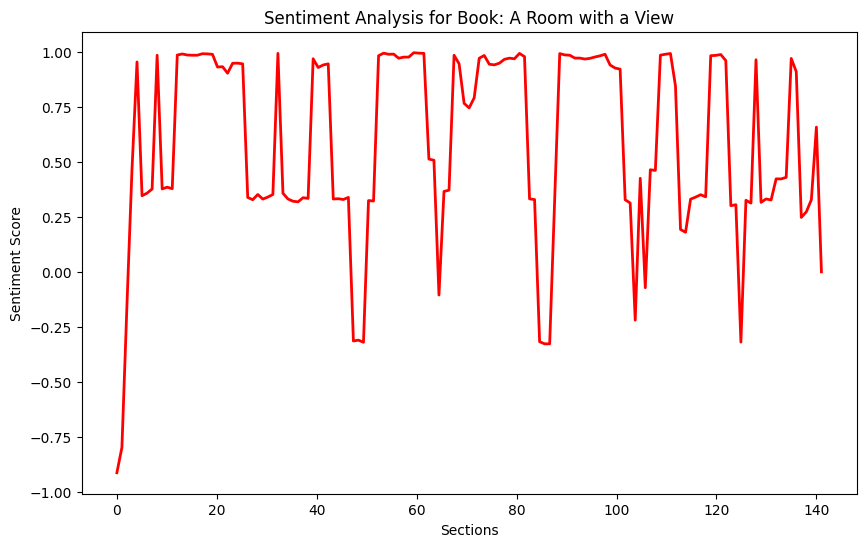

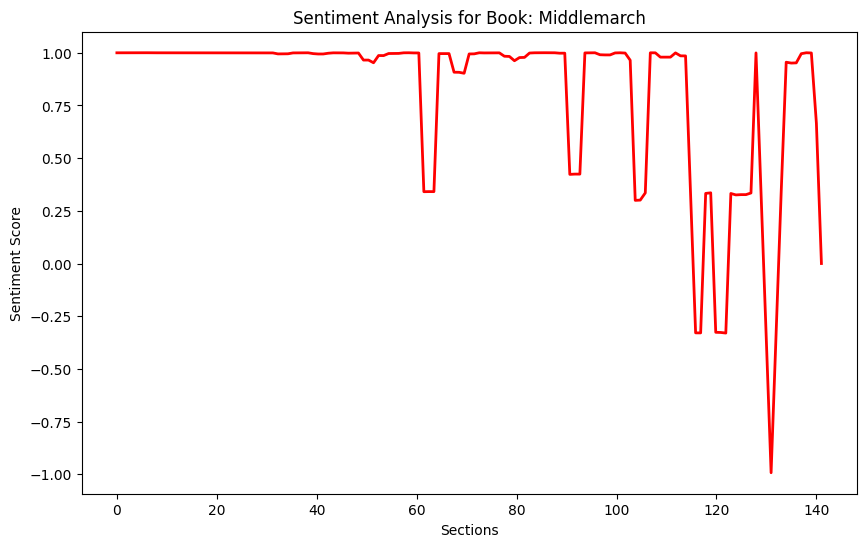

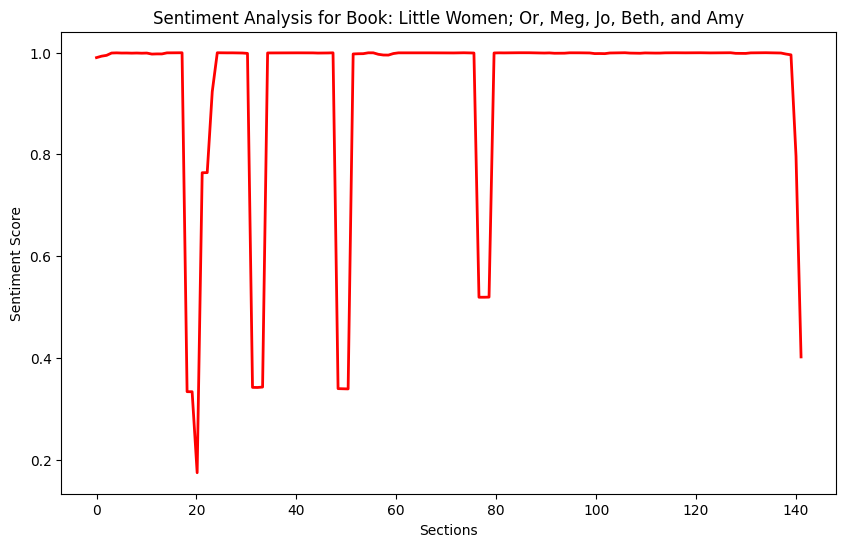

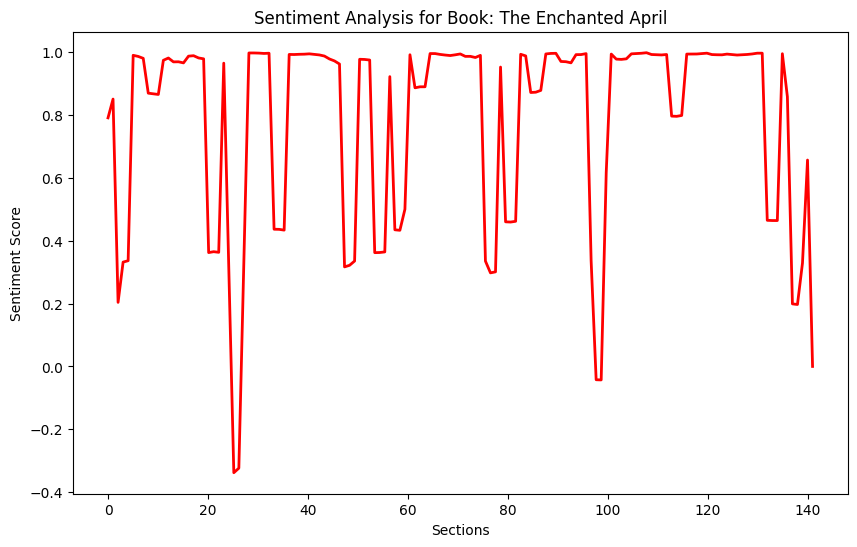

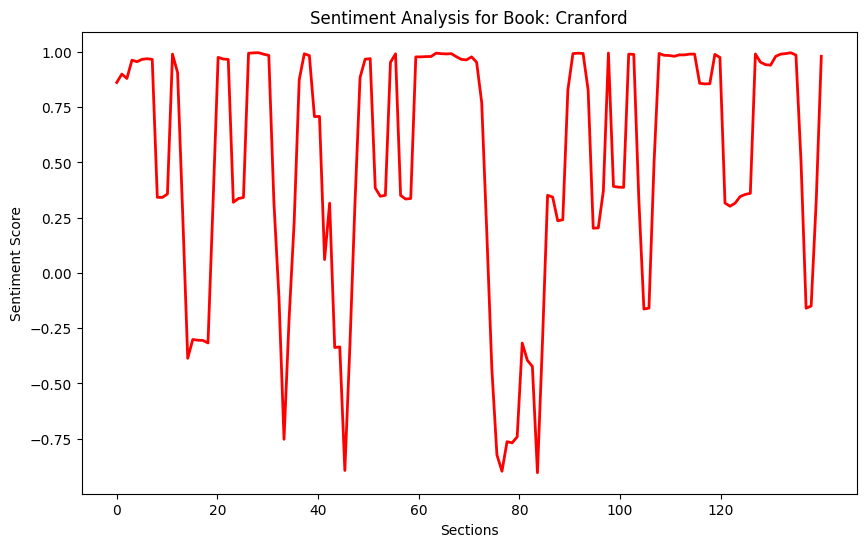

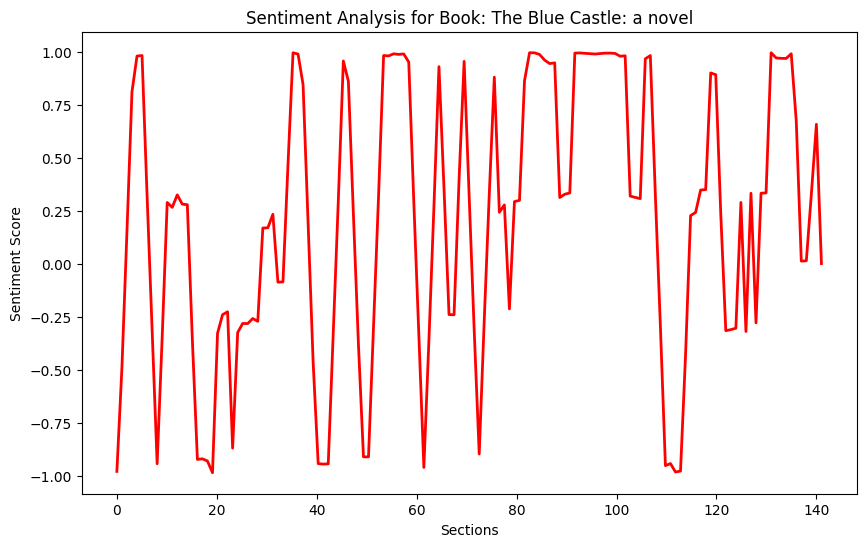

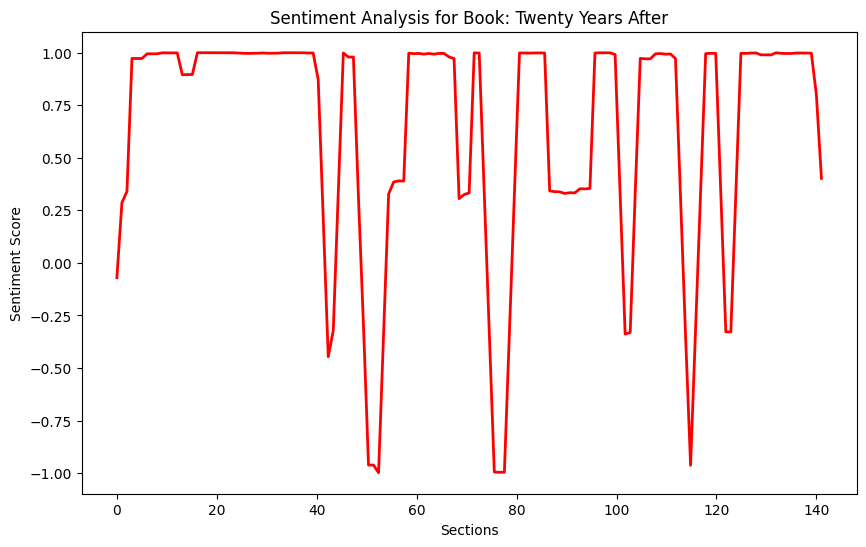

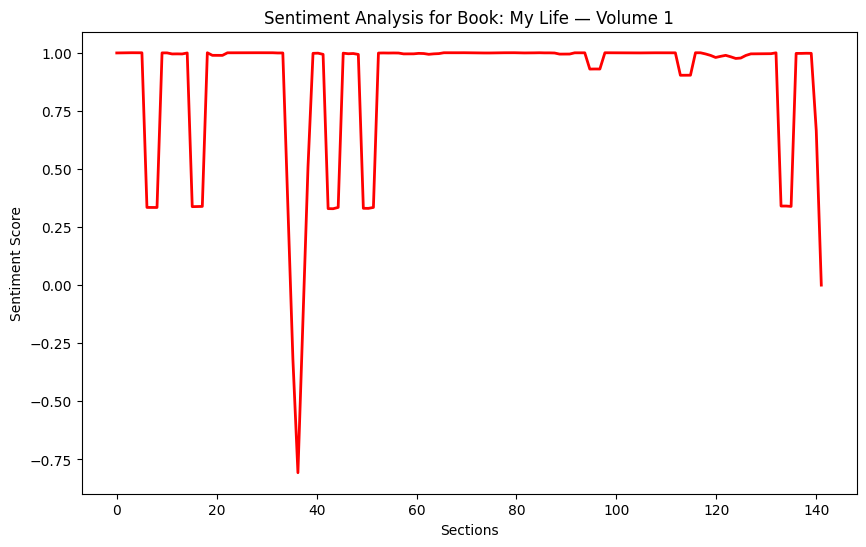

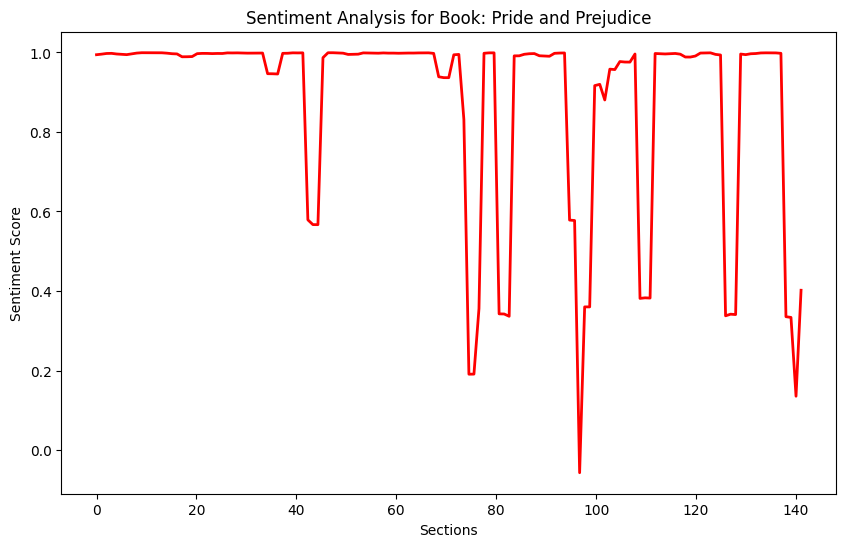

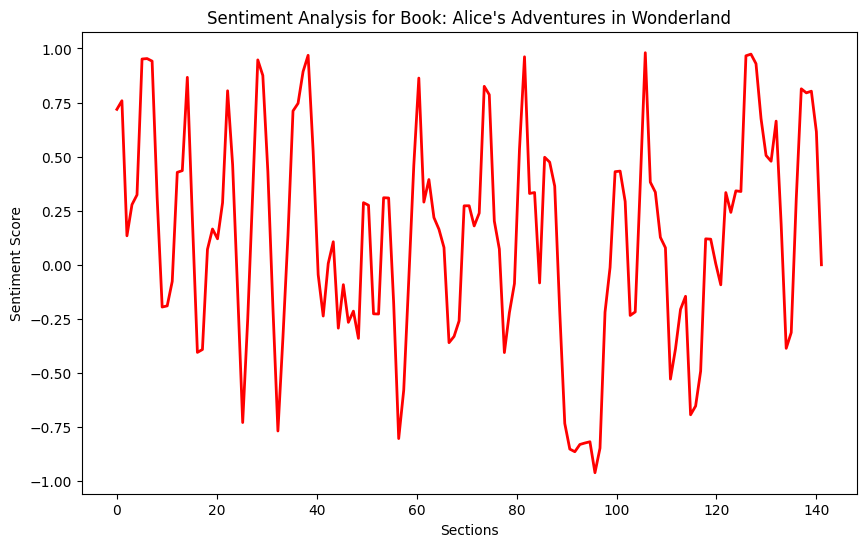

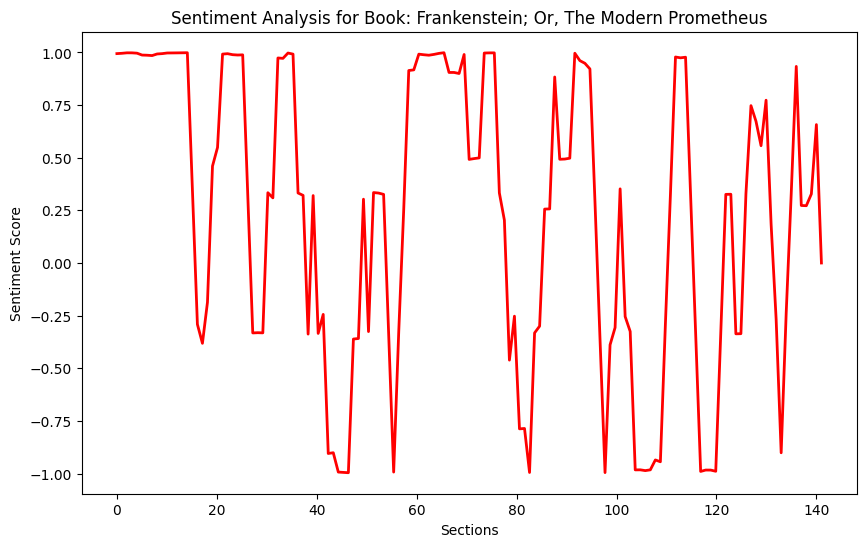

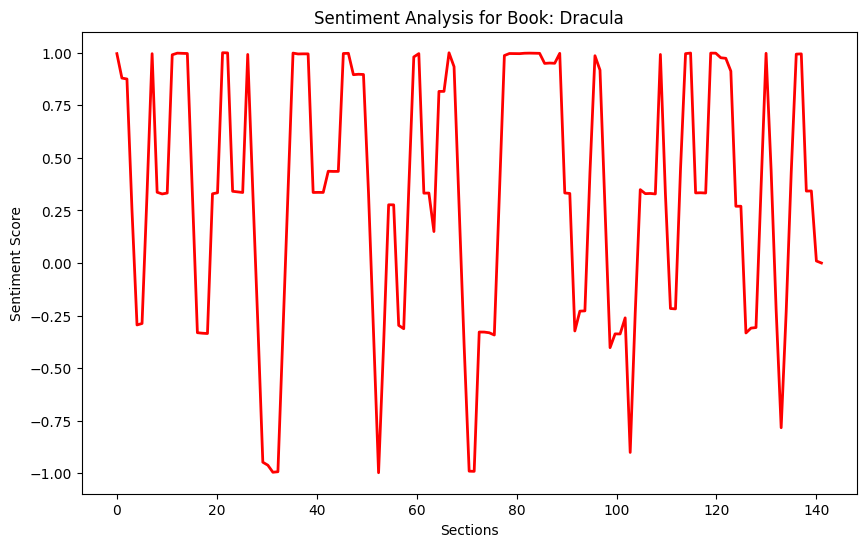

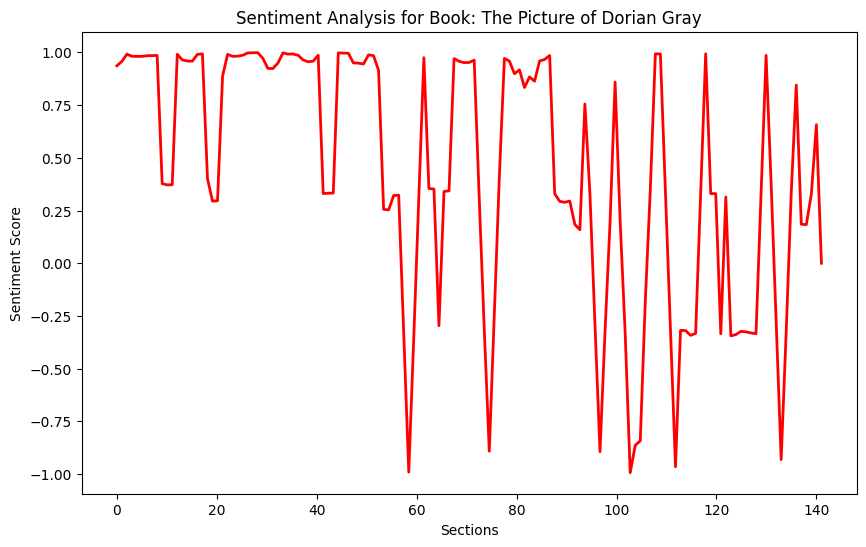

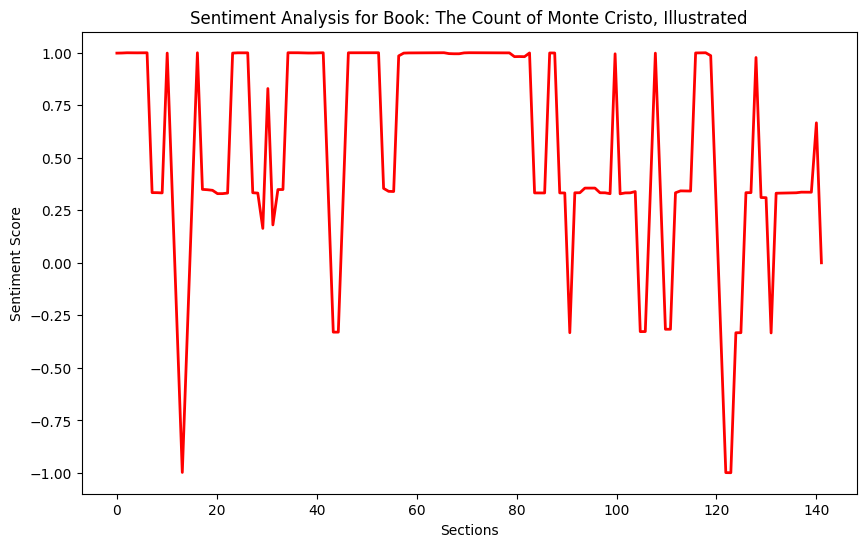

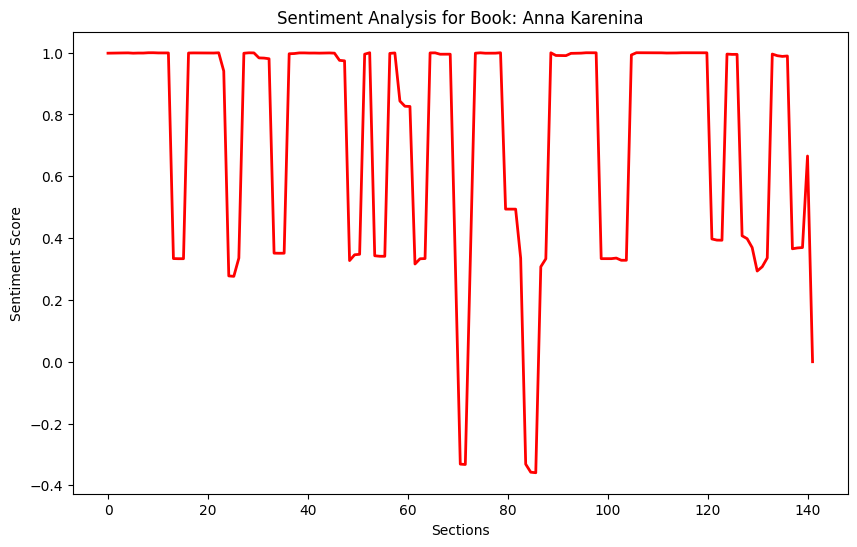

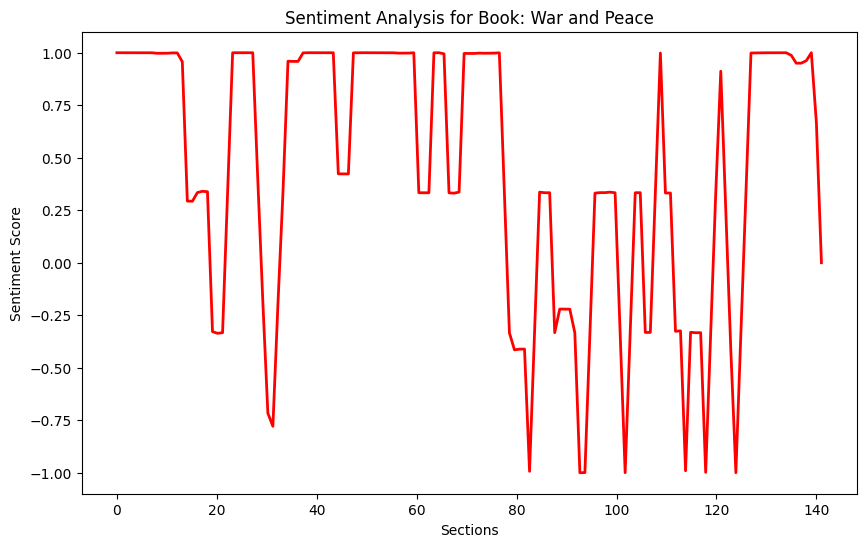

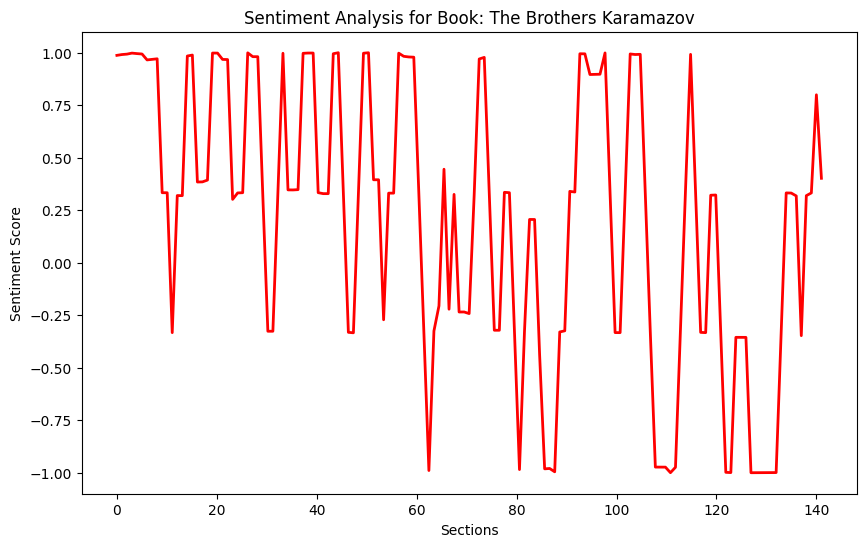

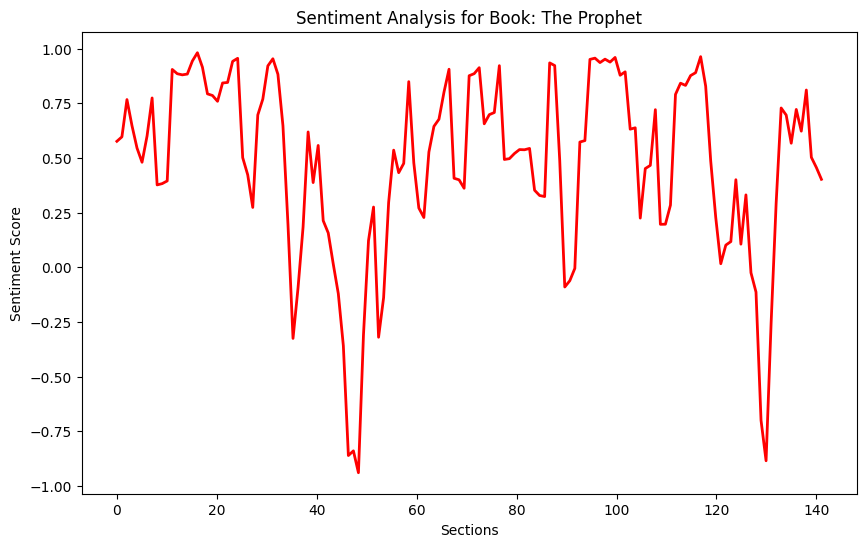

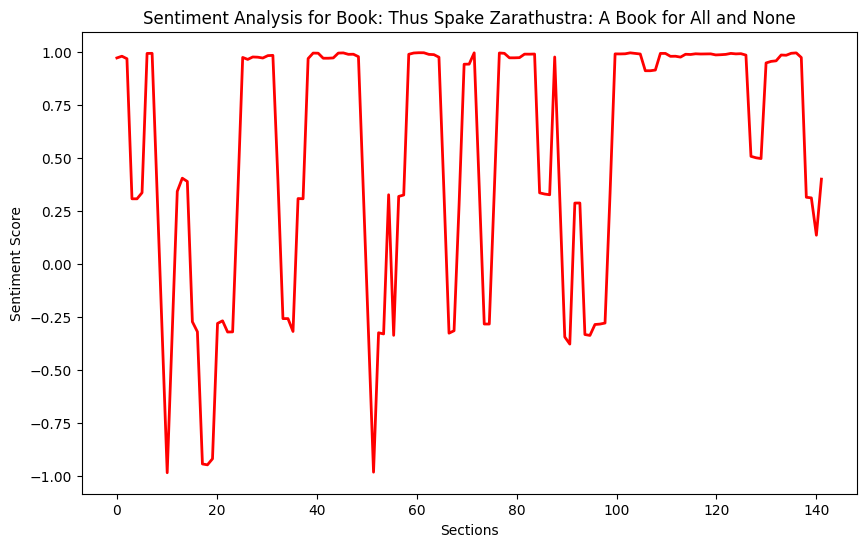

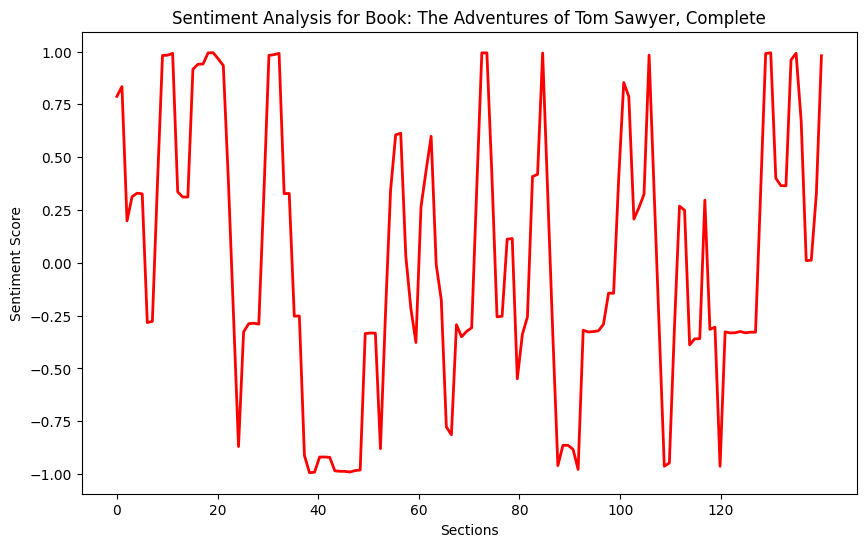

In [2]:
import os
import nltk
import numpy as np
import matplotlib.pyplot as plt
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

# Download NLTK data (if not already downloaded)
nltk.download('punkt')
nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Define the Gutendex API endpoint and parameters
GUTENDEX_API_BASE_URL = 'https://gutendex.com'
author_year_start = 1808
author_year_end = 1890
gutendex_url = f'{GUTENDEX_API_BASE_URL}/books?author_year_start={author_year_start}&author_year_end={author_year_end}'

# Create a retry session for API requests
retry_strategy = Retry(
    total=5,
    backoff_factor=2,
    status_forcelist=[429, 500, 502, 503, 504],
)
adapter = HTTPAdapter(max_retries=retry_strategy)
http = requests.Session()
http.mount("https://", adapter)
http.mount("http://", adapter)

# Load and preprocess text files
def preprocess_text(text):
    # Perform any necessary preprocessing steps here (e.g., lowercasing, removing punctuation, etc.)
    return text

# Divide texts into sections
num_sections = 140

# Function to fetch book text using the Gutendex API
def fetch_book_text(book_id):
    url = f'{GUTENDEX_API_BASE_URL}/books/{book_id}'
    try:
        response = http.get(url)
        response.raise_for_status()
        book_data = response.json()
        return book_data.get('formats', {}).get('text/plain'), book_data
    except requests.exceptions.RequestException as e:
        print(f"Failed to fetch book {book_id} text: {e}")
    return None, None

# Fetch all book IDs from the Gutendex API
def fetch_all_book_ids():
    try:
        response = http.get(gutendex_url)
        response.raise_for_status()
        books_data = response.json()
        return [book['id'] for book in books_data['results']]
    except requests.exceptions.RequestException as e:
        print(f"Failed to fetch book IDs: {e}")
    return []

# Get all book IDs
book_ids = fetch_all_book_ids()

# Create sentiment analysis charts with smoothed curve lines for each book
for i, book_id in enumerate(book_ids):
    book = {}  # Create a dictionary to store book information

    # Fetch book text using the Gutendex API
    text_url, book_data = fetch_book_text(book_id)
    if text_url is None:
        continue

    try:
        response = http.get(text_url)
        response.raise_for_status()
        text = response.text
    except requests.exceptions.RequestException as e:
        print(f"Failed to fetch text for book {book_id}: {e}")
        continue

    preprocessed_text = preprocess_text(text)

    # Initialize NLTK's SentimentIntensityAnalyzer
    sia = SentimentIntensityAnalyzer()

    sentiment_scores = [sia.polarity_scores(section)['compound'] for section in preprocessed_text.split('\n\n')]
    book['sentiment'] = np.mean(sentiment_scores)

    section_size = len(preprocessed_text) // num_sections
    sections = [preprocessed_text[i:i + section_size] for i in range(0, len(preprocessed_text), section_size)]
    book['sections'] = sections

    x = np.linspace(0, len(sections), len(sections))  # Linear section numbering
    y = [np.mean([sia.polarity_scores(section)['compound'] for section in sections[max(0, int(i) - 1):int(i) + 2]]) for i in x]

    # Get the book title from the Gutendex API response
    book_title = "Unknown Title"
    if book_data and 'title' in book_data:
        book_title = book_data['title']

    plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
    plt.plot(x, y, 'r-', linewidth=2)  # Smooth curve line

    plt.xlabel('Sections')
    plt.ylabel('Sentiment Score')
    plt.title(f'Sentiment Analysis for Book: {book_title}')

    # Calculate the positions of custom x-axis ticks
    custom_xticks_interval = 20  # Change this value to your desired interval
    custom_xticks = np.arange(0, len(sections), custom_xticks_interval)

    # Set the x-axis ticks and labels
    plt.xticks(custom_xticks, custom_xticks)

    plt.show()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


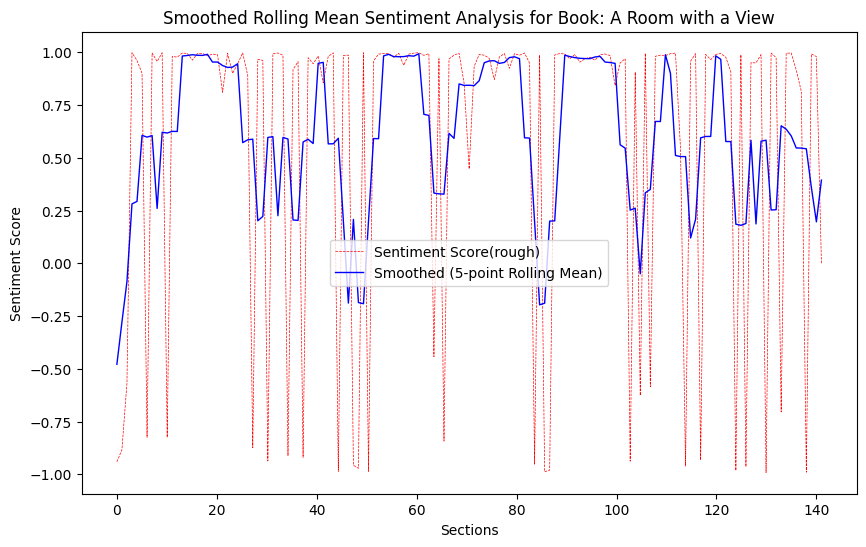

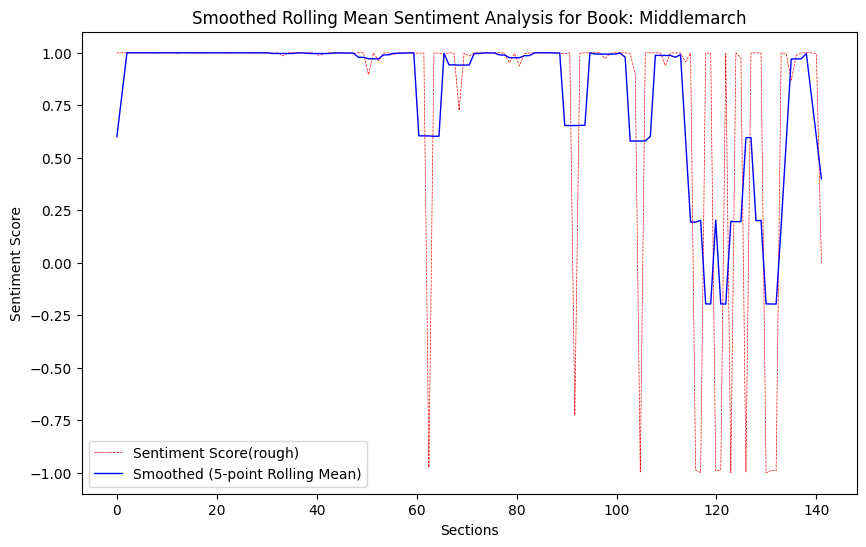

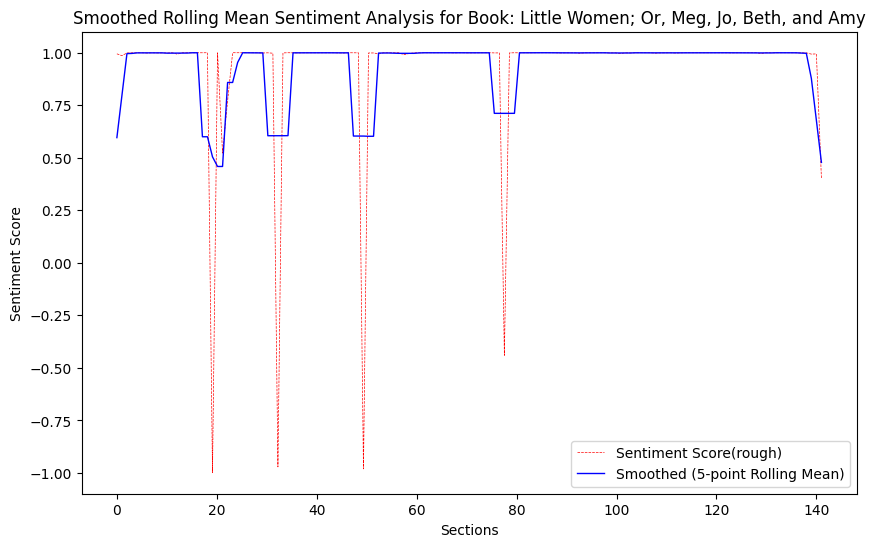

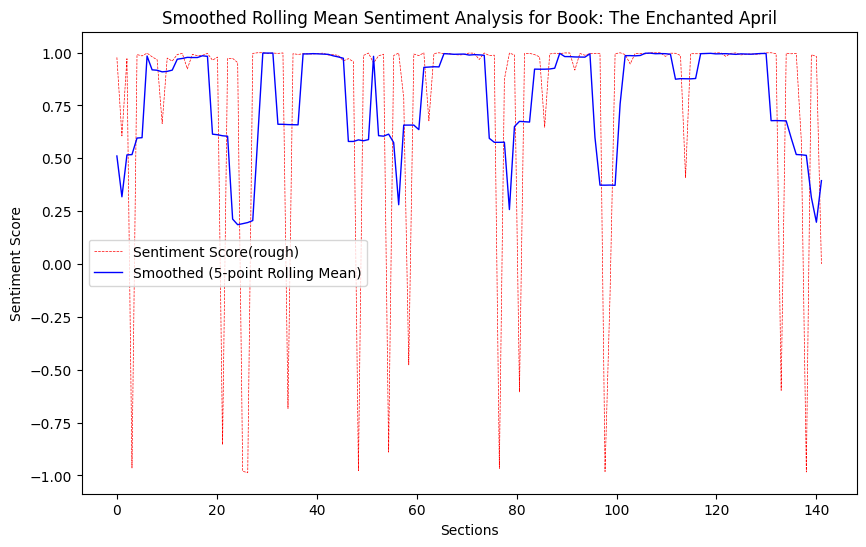

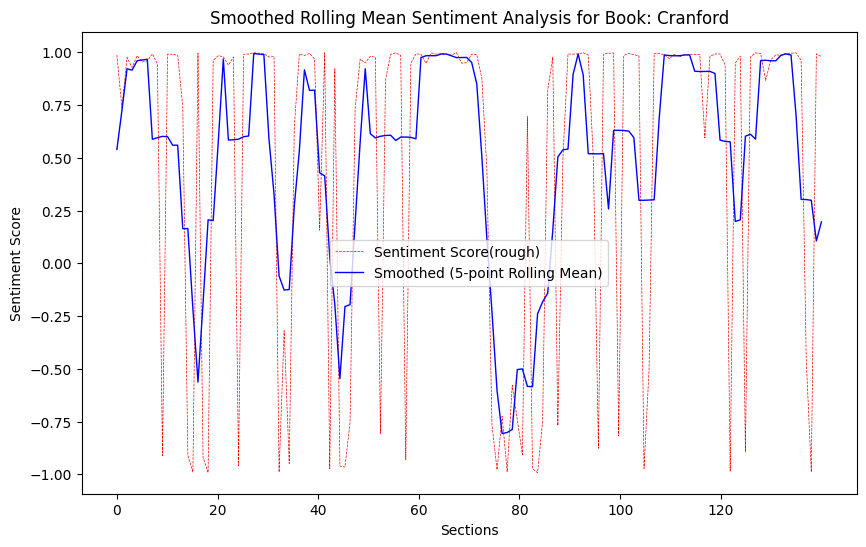

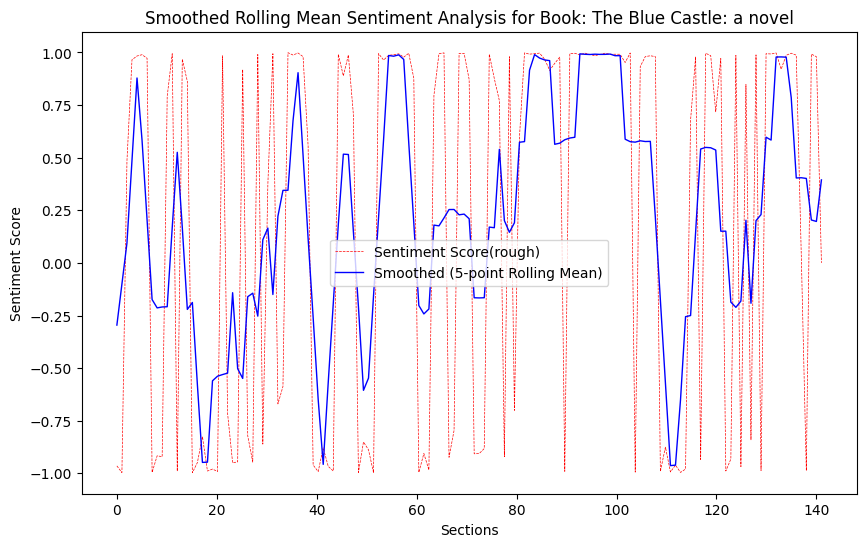

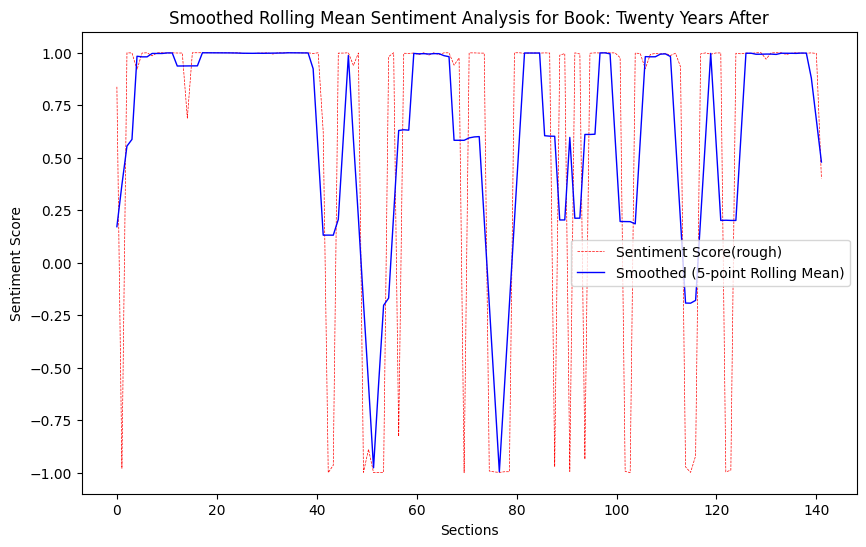

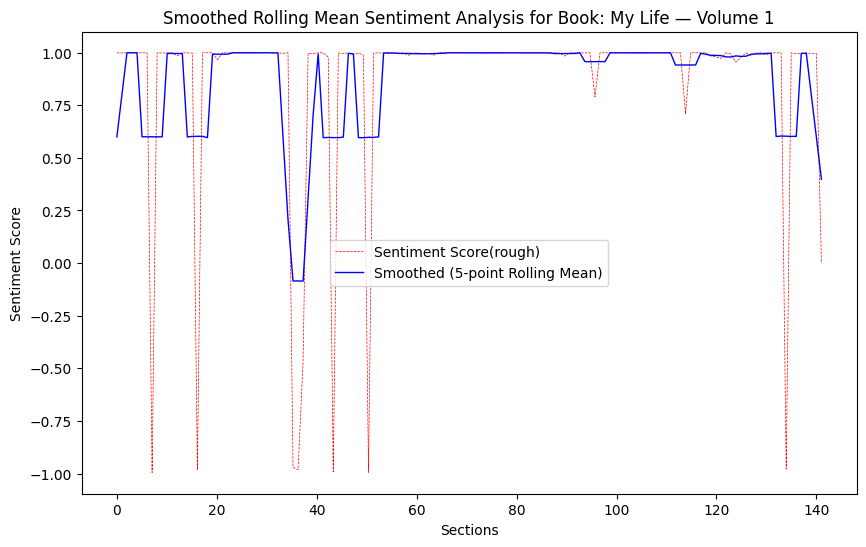

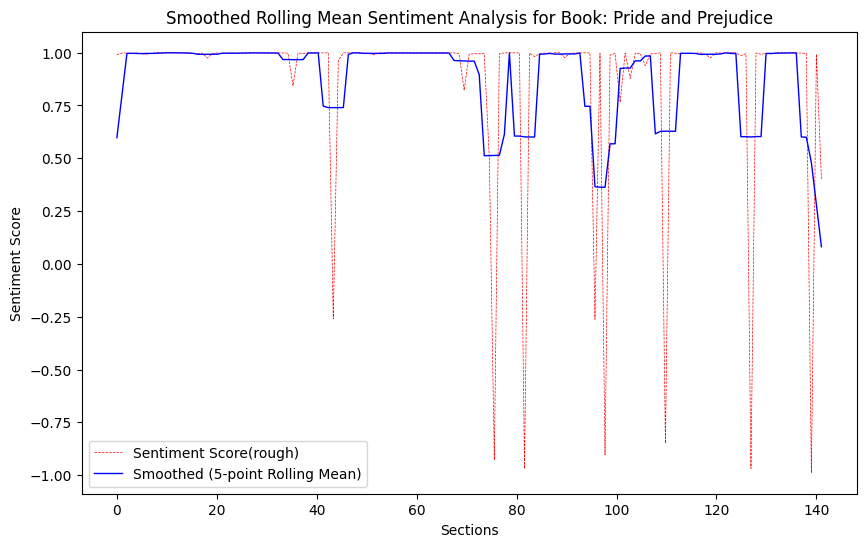

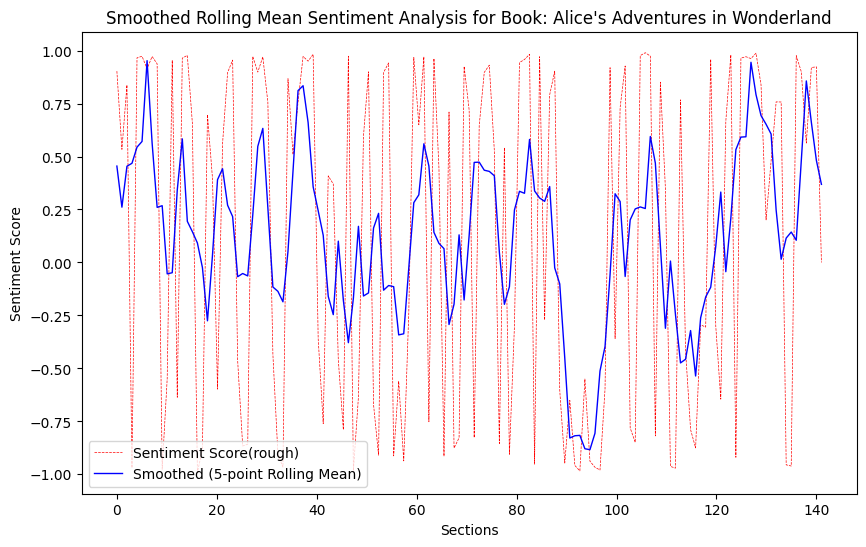

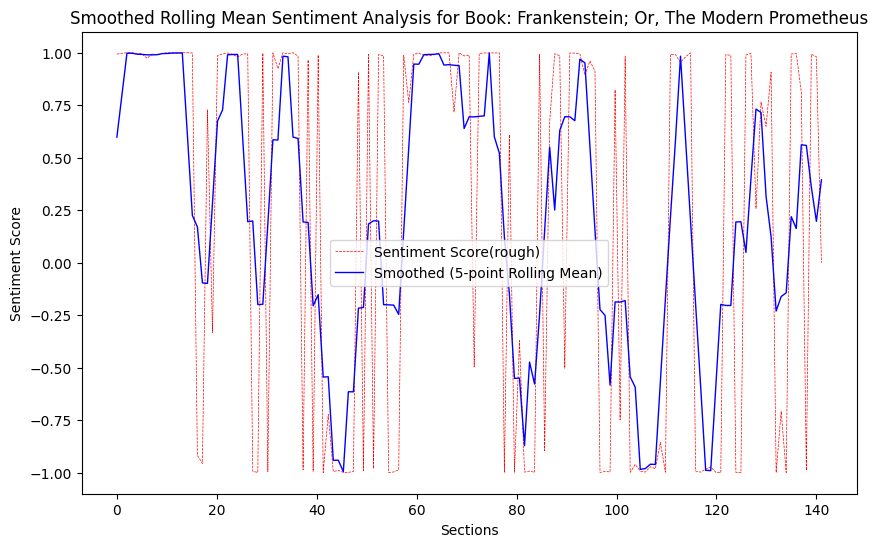

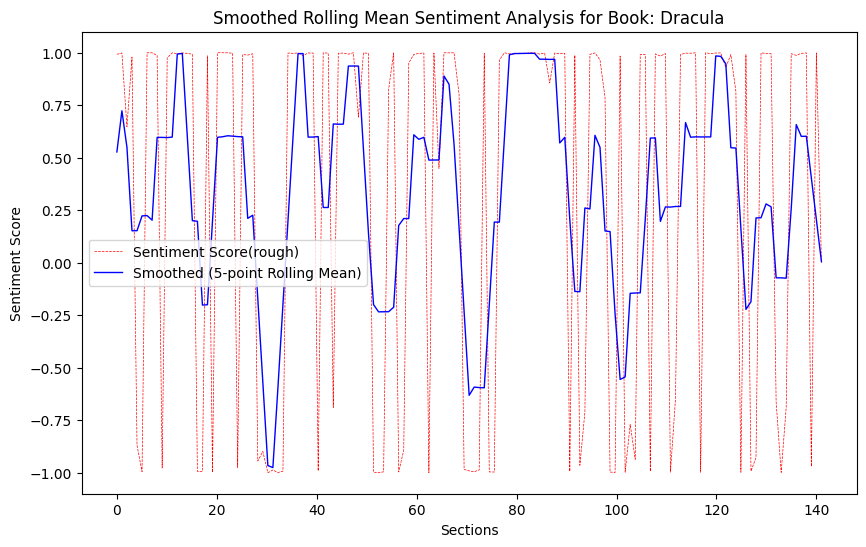

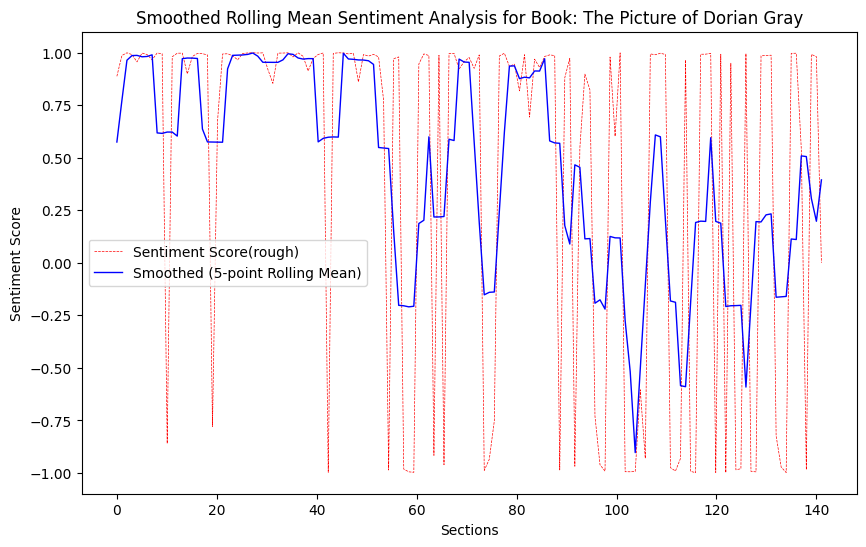

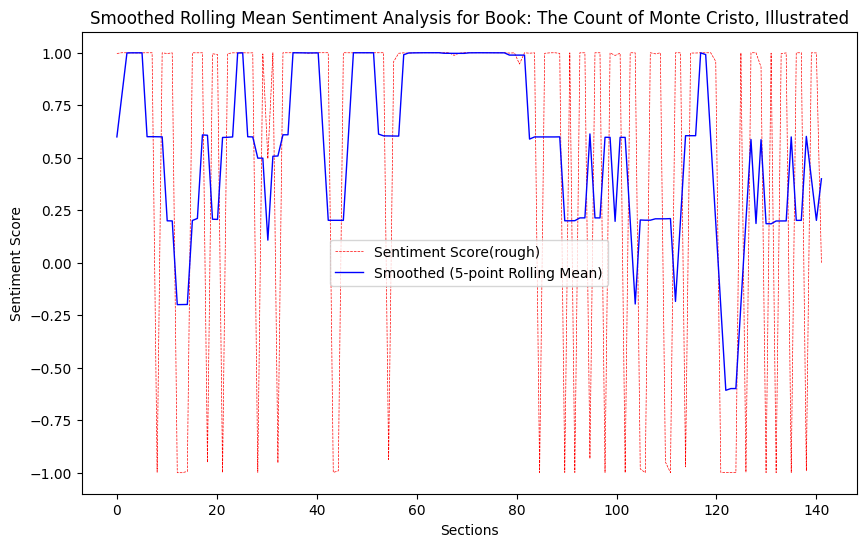

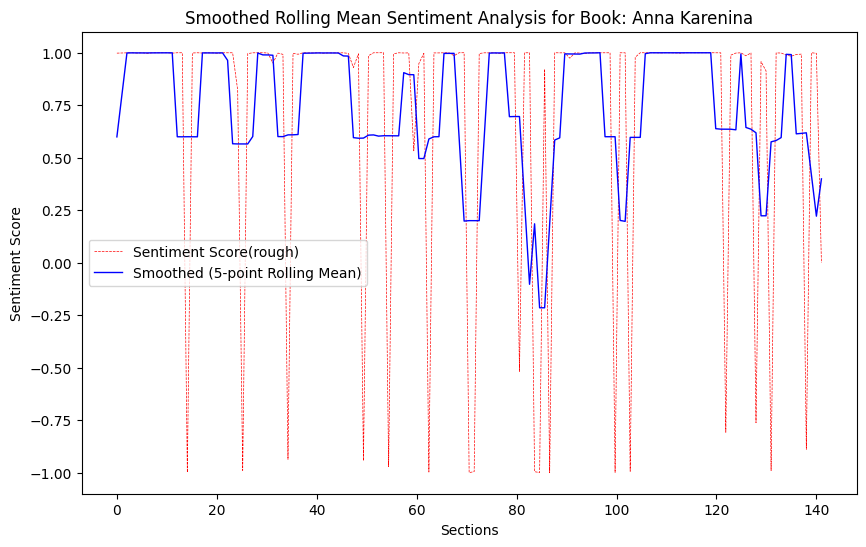

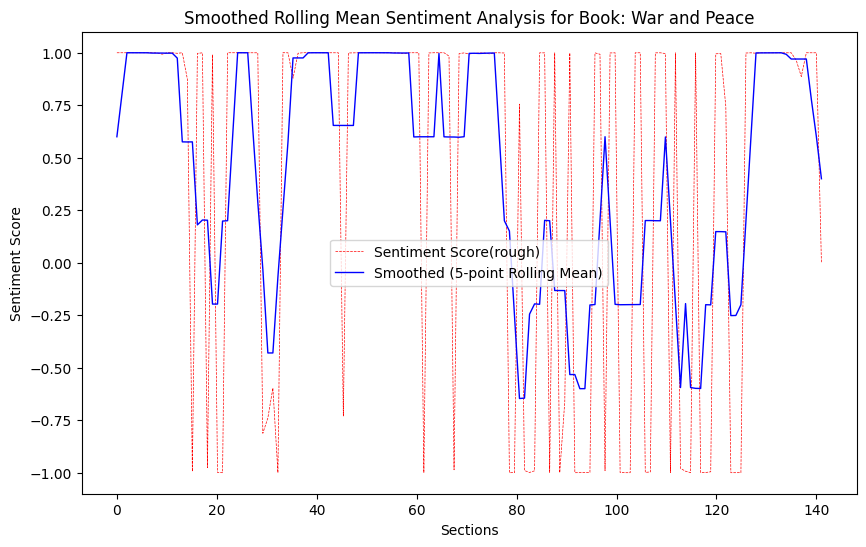

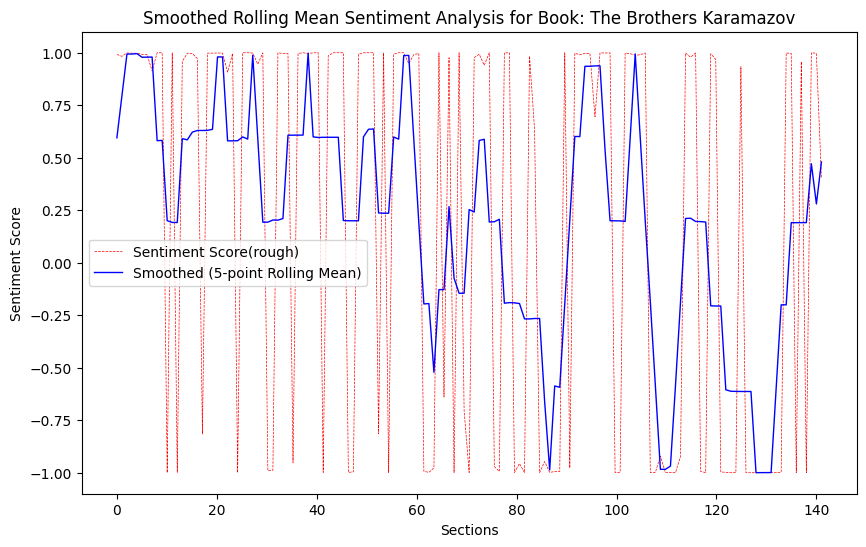

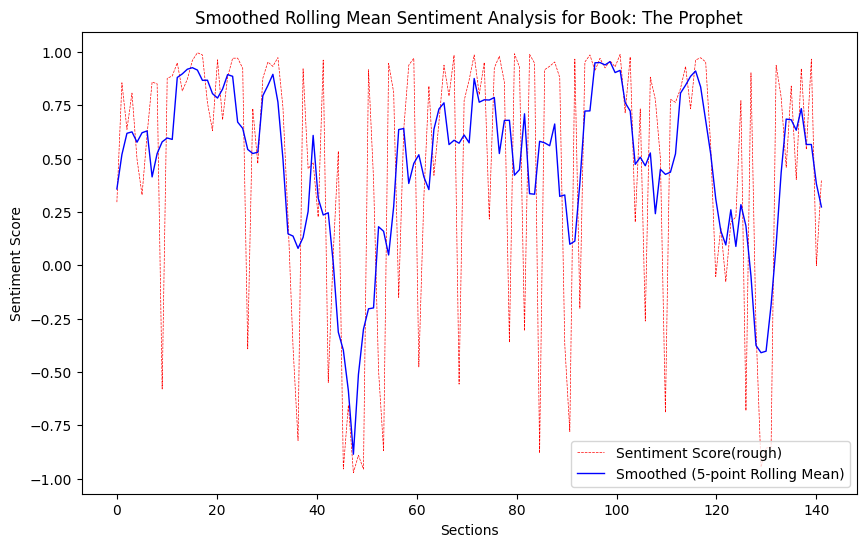

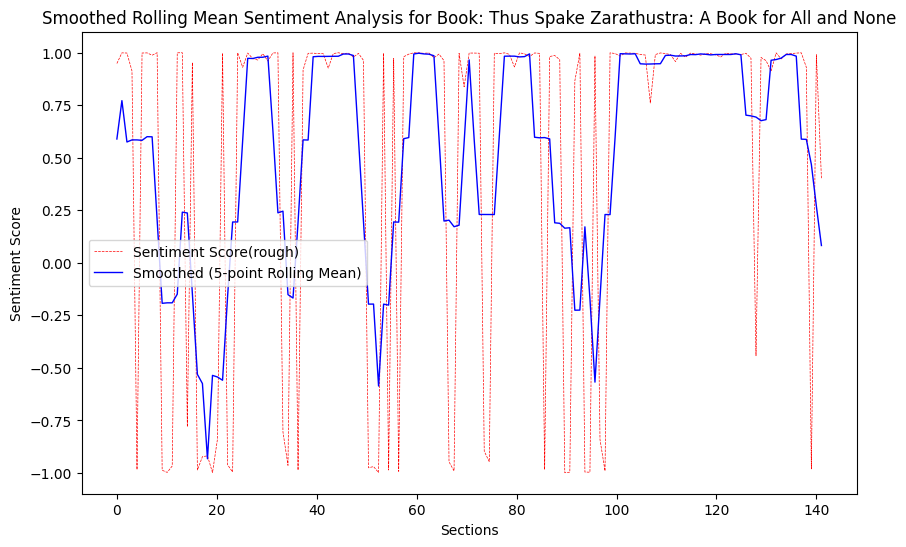

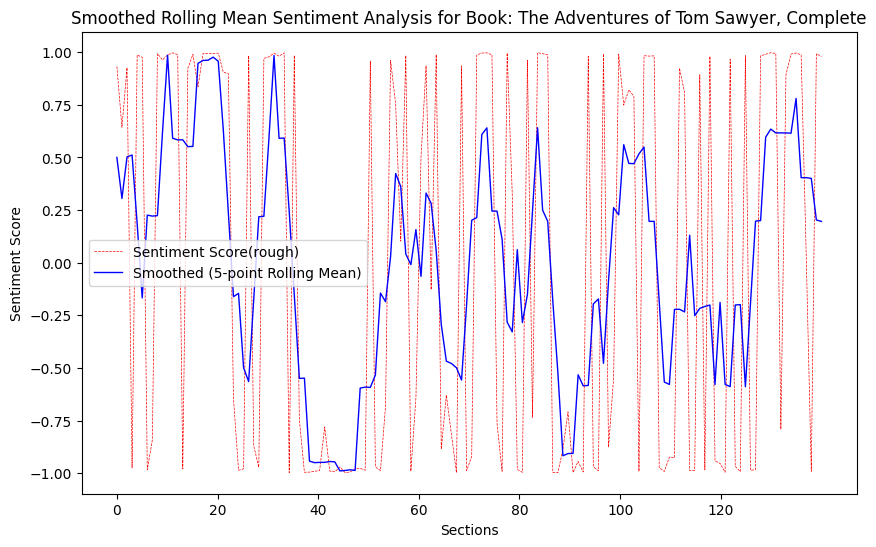

In [3]:
import nltk
import numpy as np
import matplotlib.pyplot as plt
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize

# Download NLTK data (if not already downloaded)
nltk.download('punkt')
nltk.download('vader_lexicon')

# Define the Gutendex API endpoint and parameters
GUTENDEX_API_BASE_URL = 'https://gutendex.com'
author_year_start = 1808
author_year_end = 1890
gutendex_url = f'{GUTENDEX_API_BASE_URL}/books?author_year_start={author_year_start}&author_year_end={author_year_end}'

# Create a retry session for API requests
retry_strategy = Retry(
    total=5,
    backoff_factor=2,
    status_forcelist=[429, 500, 502, 503, 504],
)
adapter = HTTPAdapter(max_retries=retry_strategy)
http = requests.Session()
http.mount("https://", adapter)
http.mount("http://", adapter)

# Load and preprocess text files
def preprocess_text(text):
    # Perform any necessary preprocessing steps here (e.g., lowercasing, removing punctuation, etc.)
    return text

# Perform sentiment analysis using NLTK's SentimentIntensityAnalyzer
def analyze_sentiment(text):
    sia = SentimentIntensityAnalyzer()
    sentiment_scores = sia.polarity_scores(text)
    sentiment_score = sentiment_scores['compound']
    return sentiment_score
# Divide texts into sections
num_sections = 140

# Function to fetch book text using the Gutendex API
def fetch_book_text(book_id):
    url = f'{GUTENDEX_API_BASE_URL}/books/{book_id}'
    try:
        response = http.get(url)
        response.raise_for_status()
        book_data = response.json()
        return book_data.get('formats', {}).get('text/plain'), book_data
    except requests.exceptions.RequestException as e:
        print(f"Failed to fetch book {book_id} text: {e}")
    return None, None

# Fetch all book IDs from the Gutendex API
def fetch_all_book_ids():
    try:
        response = http.get(gutendex_url)
        response.raise_for_status()
        books_data = response.json()
        return [book['id'] for book in books_data['results']]
    except requests.exceptions.RequestException as e:
        print(f"Failed to fetch book IDs: {e}")
    return []

# Get all book IDs
book_ids = fetch_all_book_ids()

# Create sentiment analysis charts with smoothed curve lines for each book
for i, book_id in enumerate(book_ids):
    book = {}  # Create a dictionary to store book information

    # Fetch book text using the Gutendex API
    text_url, book_data = fetch_book_text(book_id)
    if text_url is None:
        continue

    try:
        response = http.get(text_url)
        response.raise_for_status()
        text = response.text
    except requests.exceptions.RequestException as e:
        print(f"Failed to fetch text for book {book_id}: {e}")
        continue

    preprocessed_text = preprocess_text(text)

    sections = sent_tokenize(preprocessed_text)  # Tokenize text into sections (sentences)
    sentiment_scores = [analyze_sentiment(section) for section in sections]
    book['sentiment'] = sentiment_scores

    section_size = len(preprocessed_text) // num_sections
    sections = [preprocessed_text[i:i + section_size] for i in range(0, len(preprocessed_text), section_size)]
    book['sections'] = sections

    x = np.linspace(0, len(sections), len(sections))  # Linear section numbering
    y = [analyze_sentiment(section) for section in sections]

    # Calculate the smoothed rolling mean line
    rolling_window = 5  # Change this value to adjust the rolling window size
    rolling_mean = np.convolve(y, np.ones(rolling_window)/rolling_window, mode='same')

    # Get the book title from the Gutendex API response
    book_title = "Unknown Title"
    if book_data and 'title' in book_data:
        book_title = book_data['title']

    plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
    plt.plot(x, y, 'r--', linewidth=0.5, label='Sentiment Score(rough)')  # Original sentiment score line
    plt.plot(x, rolling_mean, 'b-', linewidth=1, label=f'Smoothed ({rolling_window}-point Rolling Mean)')  # Smoothed rolling mean line

    plt.xlabel('Sections')
    plt.ylabel('Sentiment Score')
    plt.title(f'Smoothed Rolling Mean Sentiment Analysis for Book: {book_title}')
    plt.legend()  # Add a legend to differentiate the lines

    # Calculate the positions of custom x-axis ticks
    custom_xticks_interval = 20  # Change this value to your desired interval
    custom_xticks = np.arange(0, len(sections), custom_xticks_interval)

    # Set the x-axis ticks and labels
    plt.xticks(custom_xticks, custom_xticks)

    plt.show()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Processing book 1/32
Processing book 2/32


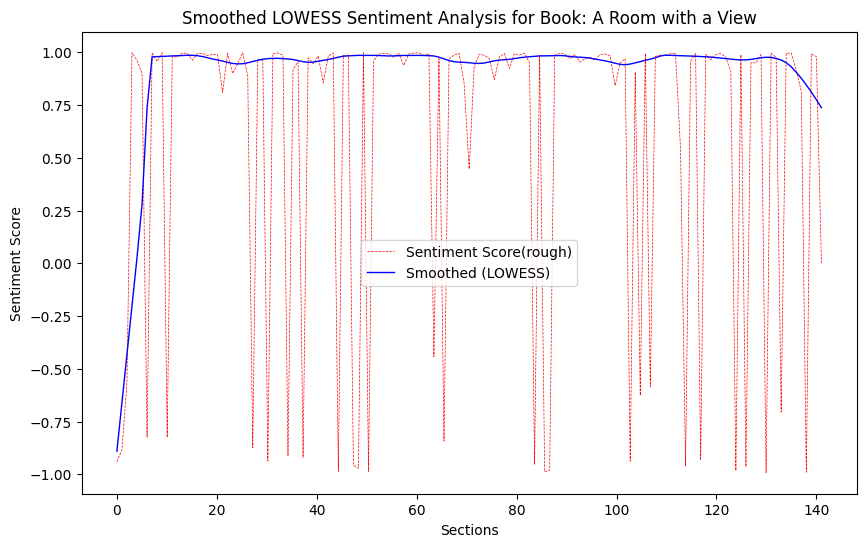

Processing book 3/32


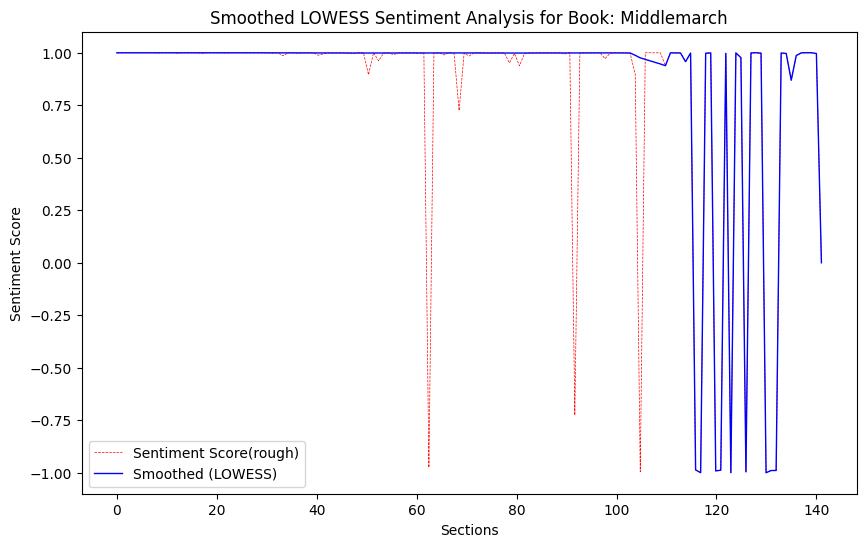

Processing book 4/32


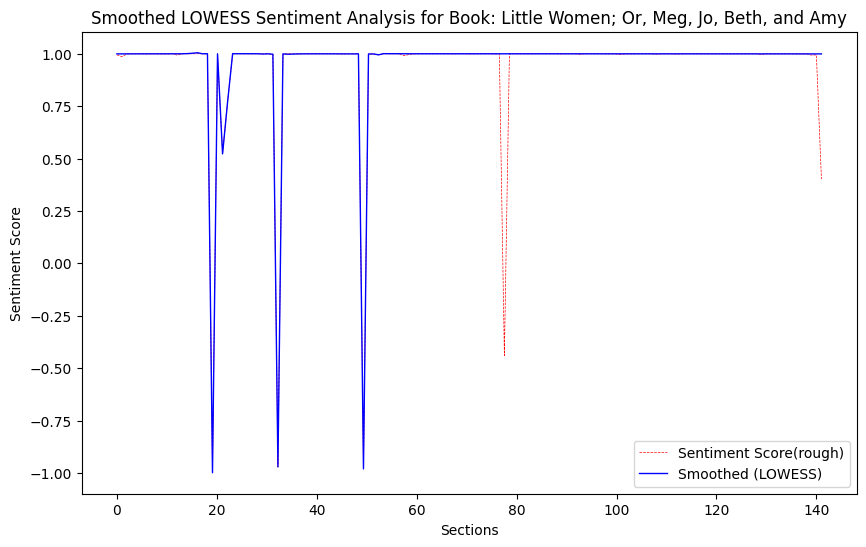

Processing book 5/32


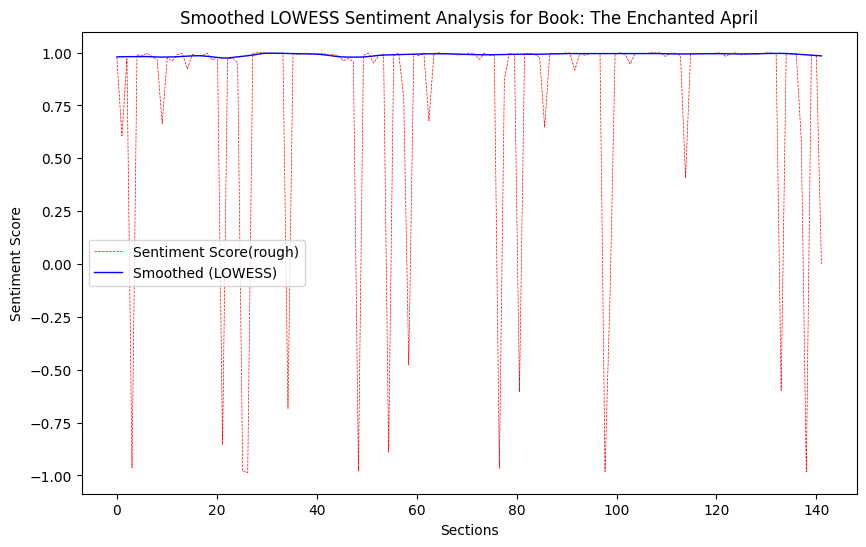

Processing book 6/32


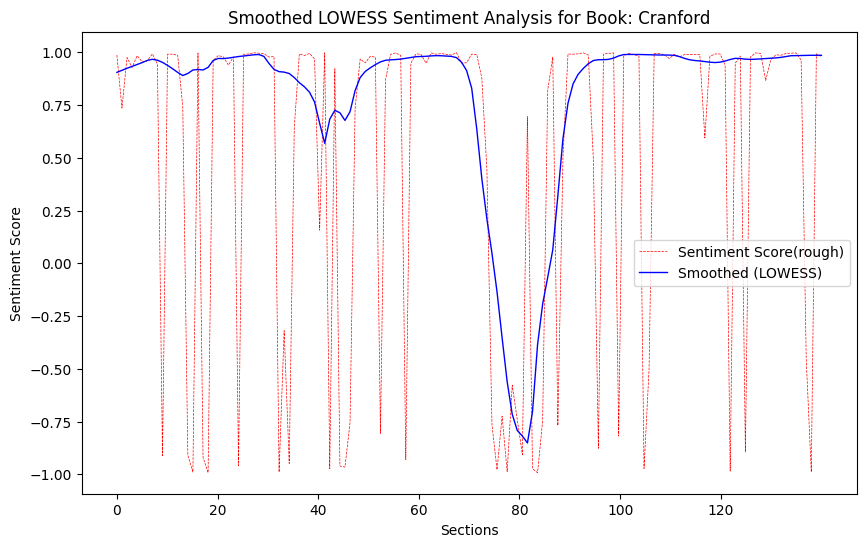

Processing book 7/32


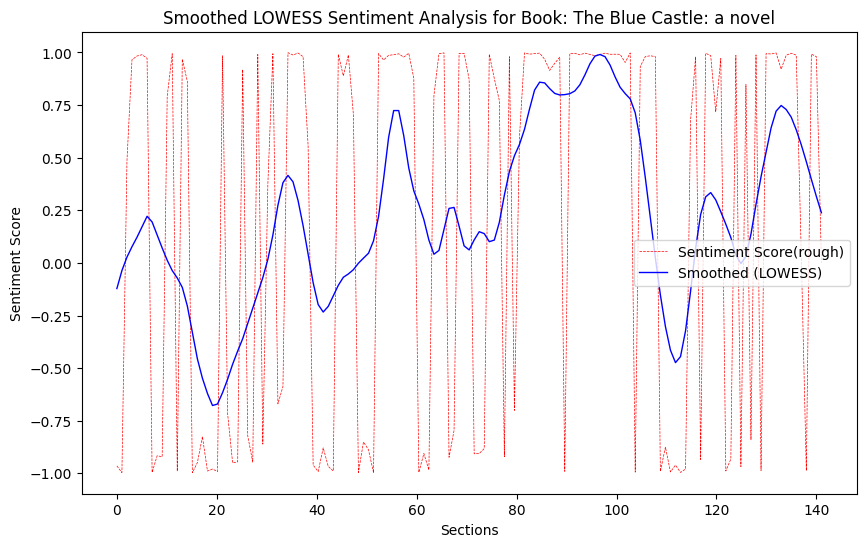

Processing book 8/32


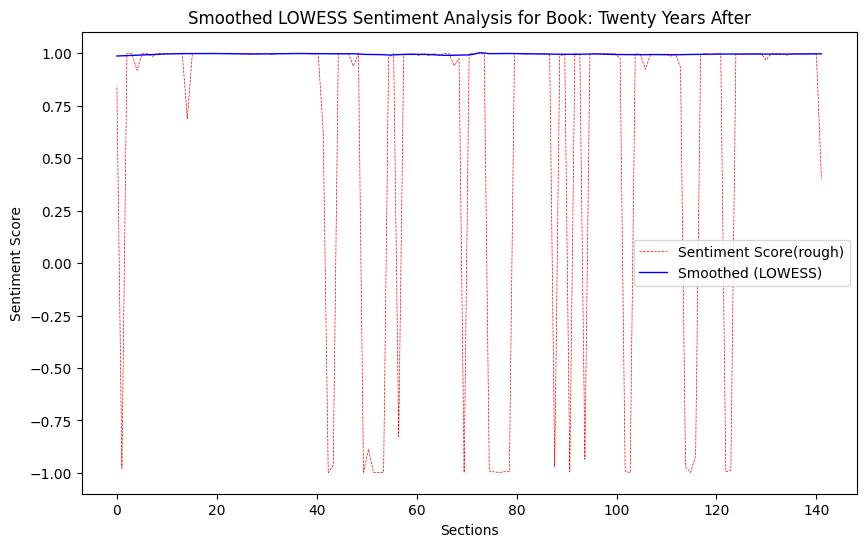

Processing book 9/32


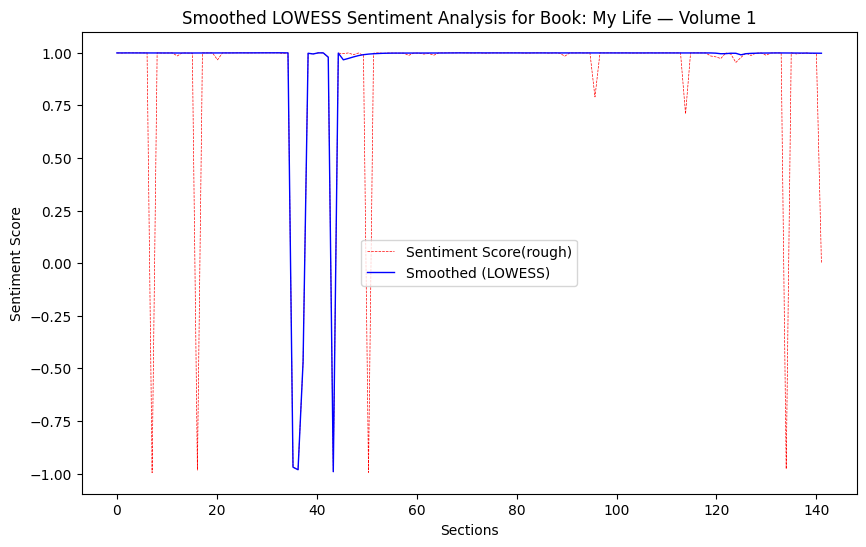

Processing book 10/32


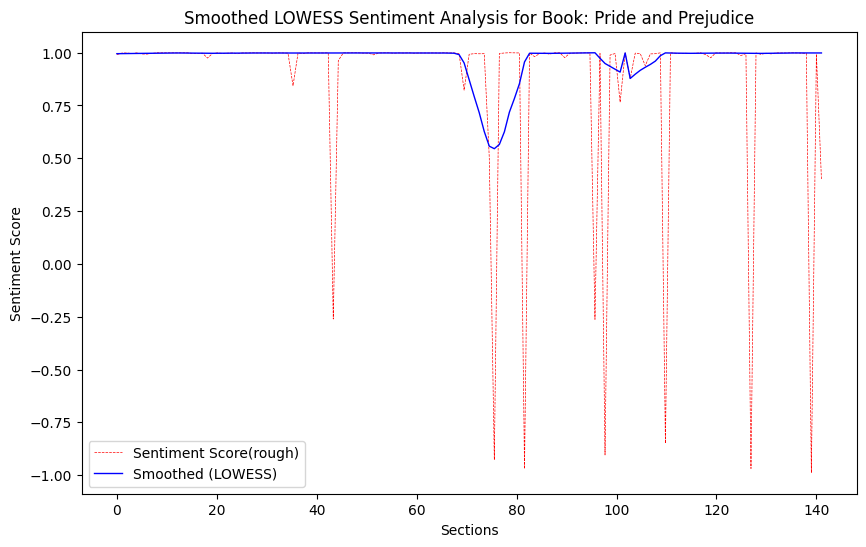

Processing book 11/32


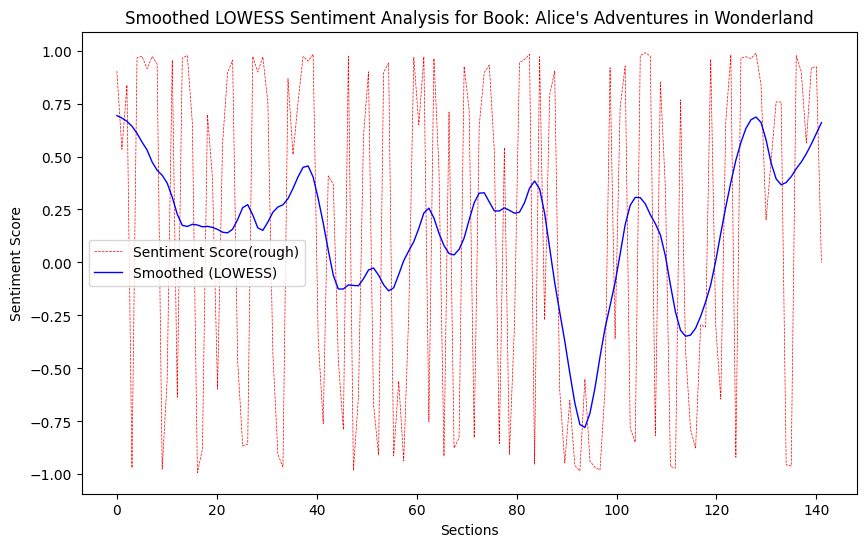

Processing book 12/32


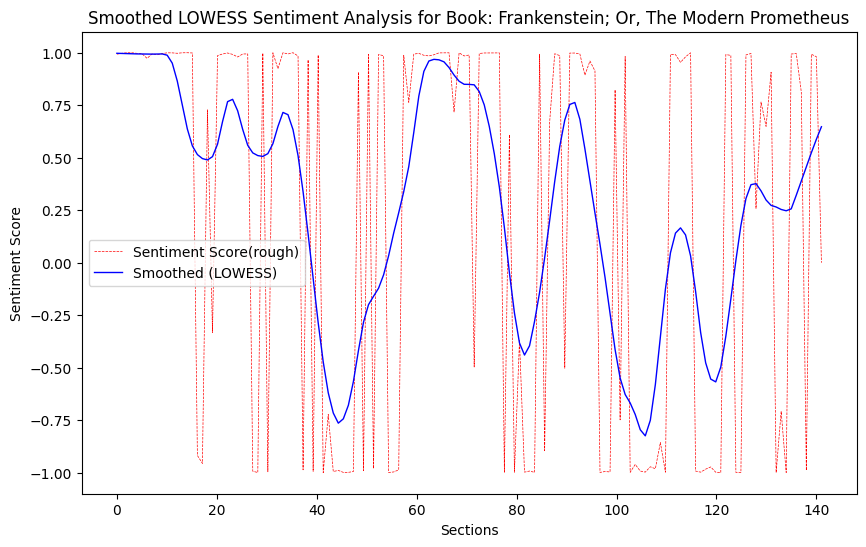

Processing book 13/32
Processing book 14/32
Processing book 15/32


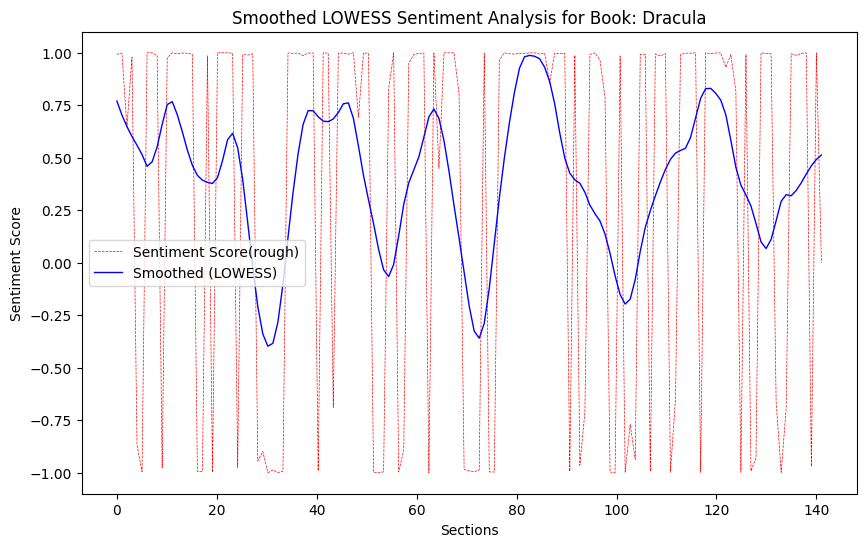

Processing book 16/32
Processing book 17/32


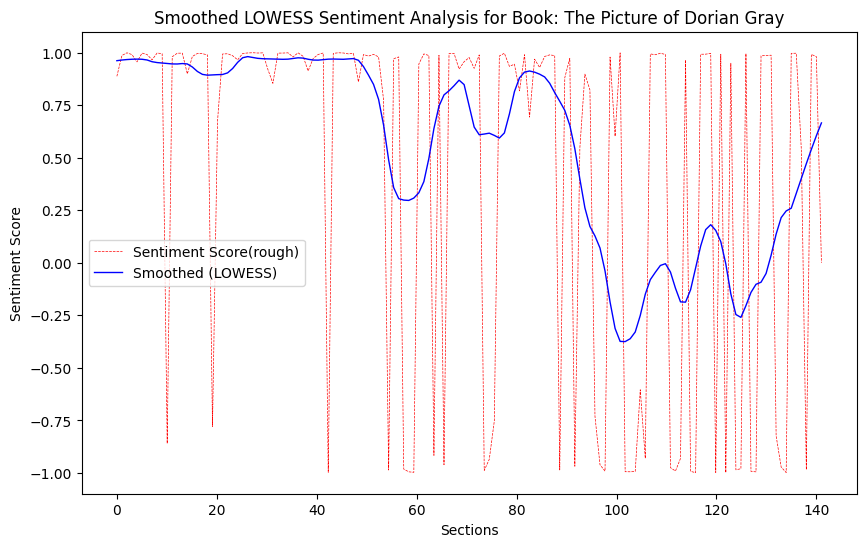

Processing book 18/32


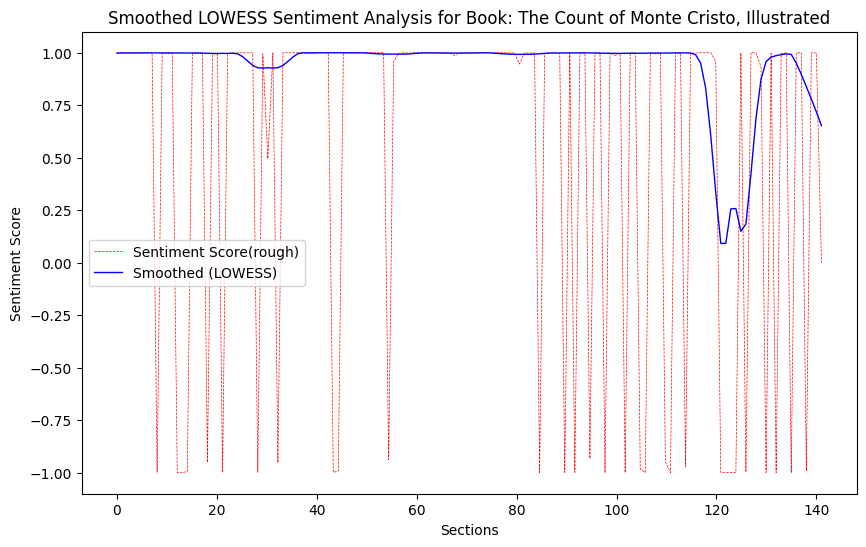

Processing book 19/32


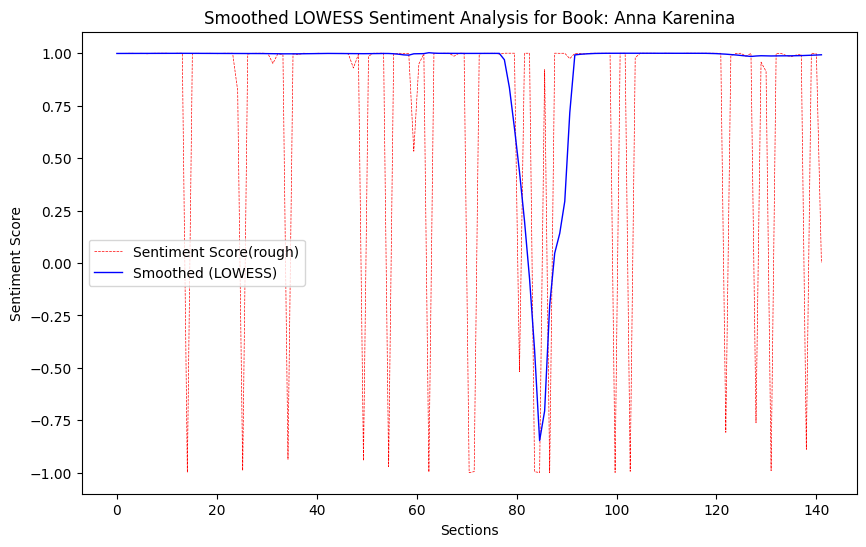

Processing book 20/32


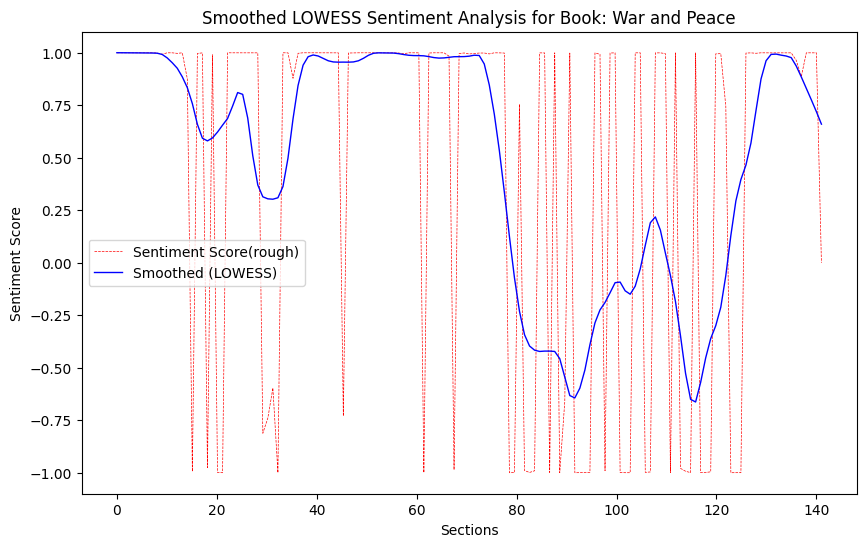

Processing book 21/32


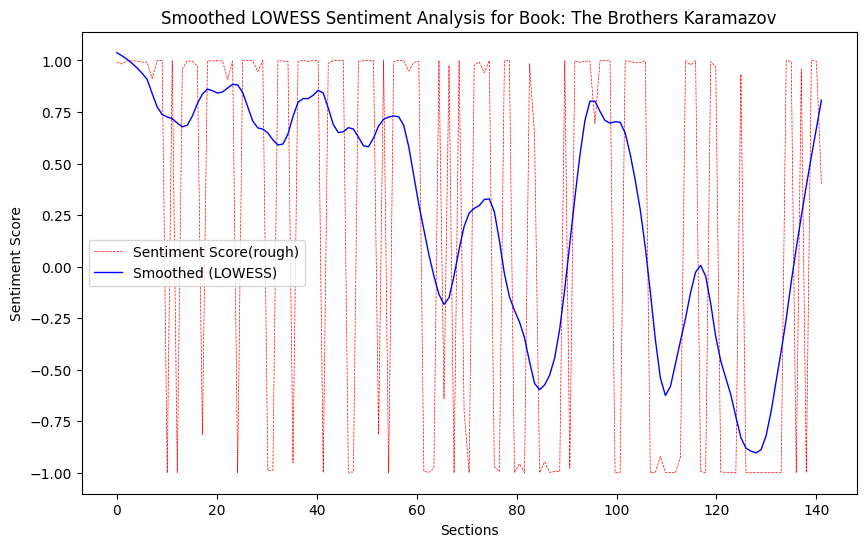

Processing book 22/32
Processing book 23/32
Processing book 24/32
Processing book 25/32
Processing book 26/32
Processing book 27/32


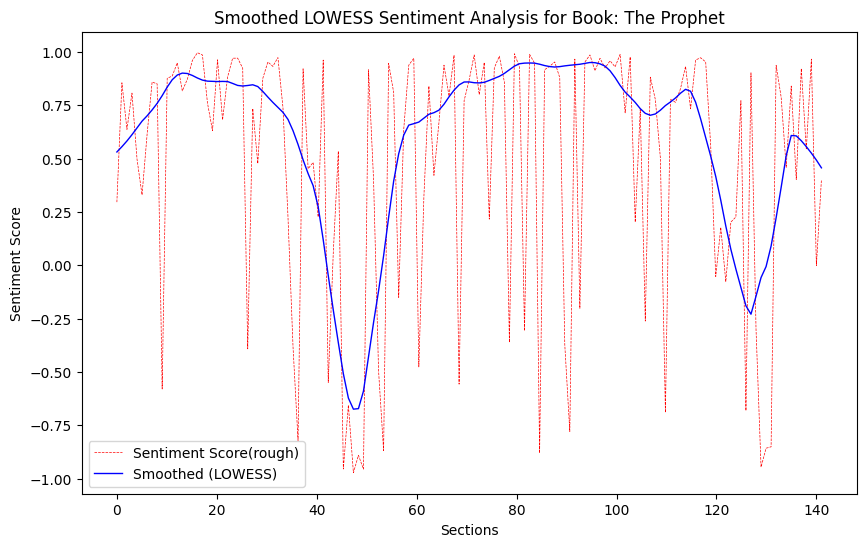

Processing book 28/32
Processing book 29/32
Processing book 30/32


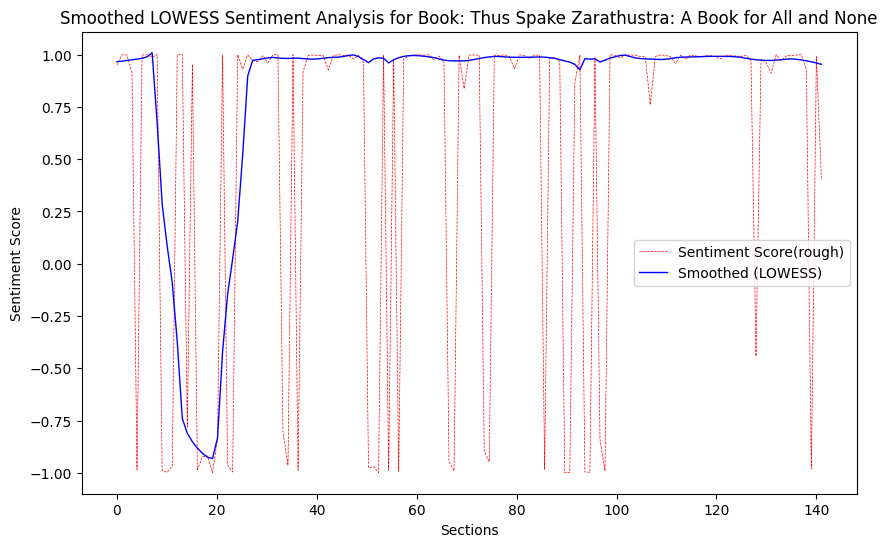

Processing book 31/32


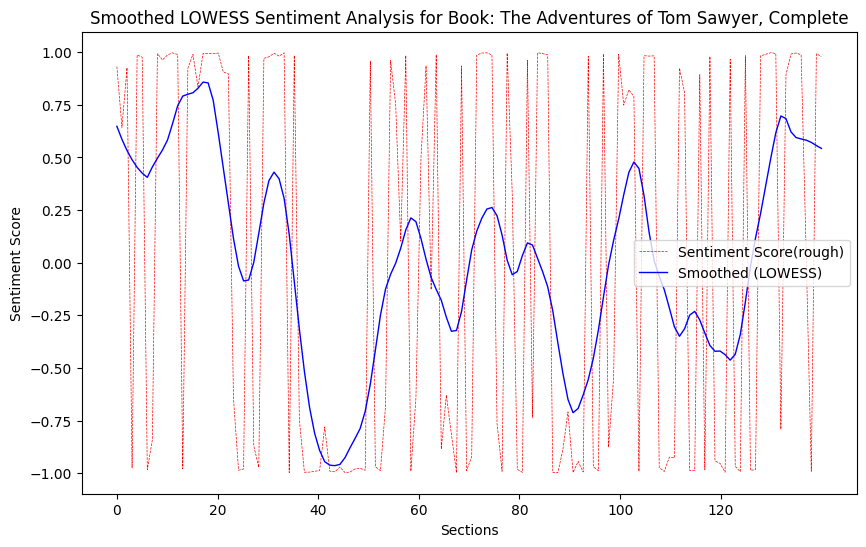

Processing book 32/32


In [4]:
import nltk
import numpy as np
import matplotlib.pyplot as plt
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
from statsmodels.nonparametric.smoothers_lowess import lowess

nltk.download('punkt')
nltk.download('vader_lexicon')  # Download the VADER lexicon for sentiment analysis

from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Define constants and functions as in your original code...

# Inside the loop where you're analyzing and plotting sentiment for each book
for i, book_id in enumerate(book_ids):
    print(f"Processing book {i + 1}/{len(book_ids)}")
    book = {}

    text_url, book_data = fetch_book_text(book_id)
    if text_url is None:
        continue

    try:
        response = http.get(text_url)
        response.raise_for_status()
        text = response.text
    except requests.exceptions.RequestException as e:
        print(f"Failed to fetch text for book {book_id}: {e}")
        continue

    preprocessed_text = preprocess_text(text)

    sentiment_scores = analyze_sentiment(preprocessed_text)  # Replace with NLTK sentiment analysis
    book['sentiment'] = sentiment_scores

    section_size = len(preprocessed_text) // num_sections
    sections = [preprocessed_text[i:i + section_size] for i in range(0, len(preprocessed_text), section_size)]
    book['sections'] = sections

    # Replace TextBlob sentiment analysis with NLTK's VADER SentimentIntensityAnalyzer
    sia = SentimentIntensityAnalyzer()
    y = [sia.polarity_scores(section)['compound'] for section in sections]

    x = np.linspace(0, len(sections), len(sections))

    # Calculate LOWESS smoothed line
    smoothed_line = lowess(y, x, frac=0.1)

    book_title = "Unknown Title"
    if book_data and 'title' in book_data:
        book_title = book_data['title']

    plt.figure(figsize=(10, 6))
    plt.plot(x, y, 'r--', linewidth=0.5, label='Sentiment Score(rough)')
    plt.plot(smoothed_line[:, 0], smoothed_line[:, 1], 'b-', linewidth=1, label='Smoothed (LOWESS)')

    plt.xlabel('Sections')
    plt.ylabel('Sentiment Score')
    plt.title(f'Smoothed LOWESS Sentiment Analysis for Book: {book_title}')
    plt.legend()

    custom_xticks_interval = 20
    custom_xticks = np.arange(0, len(sections), custom_xticks_interval)
    plt.xticks(custom_xticks, custom_xticks)

    plt.show()
